## Key Learning

* `model.init()` - Call this once to create initial params and state Pytrees. Requires a PRNGKey and dummy input data to infer all necessary shapes
* `model.apply()` : Call this for every forward pass. We must provide params, state and input data. Executes logic inside `__call__()` method
* nn.Module is a blueprint and not a container. It is stateless and parameters are stored independently
* We must explicitly pass in a boolean flag (train = True) through our model and use it to control behavior of layers like Batchnorm, dropout

## Resnet Specific
* We have a `block_class` argument which helps us build generic containers. In this code we can use it to either use original resnet or pre activation resnet blocks
* Using `subsample` we implement conditional logic for downsampling


In [3]:
## Standard libraries
import os
import numpy as np
from PIL import Image
from typing import Any
from collections import defaultdict
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

/tmp/ipython-input-3-356270091.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/saved_models/resnet"

print("Device:", jax.devices()[0])

Device: cuda:0


In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial5/"
# Files to download
pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "PreActResNet.ckpt", "DenseNet.ckpt",
                    "tensorboards/GoogleNet/events.out.tfevents.googlenet",
                    "tensorboards/ResNet/events.out.tfevents.resnet",
                    "tensorboards/PreActResNet/events.out.tfevents.preactresnet",
                    "tensorboards/DenseNet/events.out.tfevents.densenet"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [6]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

100%|██████████| 170M/170M [00:12<00:00, 13.5MB/s]


Data mean [0.49139968 0.48215841 0.44653091]
Data std [0.24703223 0.24348513 0.26158784]


In [7]:
# Transformations applied on each image => bring them into a numpy array
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(axis=(0,1,2)))
print("Batch std", imgs.std(axis=(0,1,2)))

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch mean [0.10288438 0.100559   0.11803646]
Batch std [0.98714554 0.99074745 1.01425226]


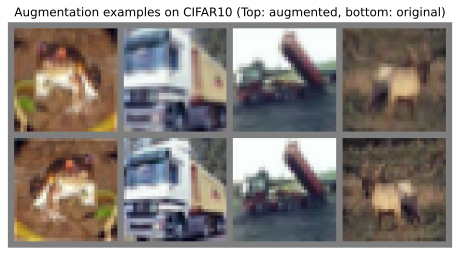

In [9]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

imgs = np.stack(images + orig_images, axis=0)
imgs = torch.from_numpy(imgs).permute(0, 3, 1, 2)
img_grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10 (Top: augmented, bottom: original)")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [10]:
class TrainState(train_state.TrainState):
    # A simple extension of TrainState to also include batch statistics
    batch_stats: Any

In [11]:
class TrainerModule:

    def __init__(self,
                 model_name : str,
                 model_class : nn.Module,
                 model_hparams : dict,
                 optimizer_name : str,
                 optimizer_hparams : dict,
                 exmp_imgs : Any,
                 seed=42):
        """
        Module for summarizing all training functionalities for classification on CIFAR10.

        Inputs:
            model_name - String of the class name, used for logging and saving
            model_class - Class implementing the neural network
            model_hparams - Hyperparameters of the model, used as input to model constructor
            optimizer_name - String of the optimizer name, supporting ['sgd', 'adam', 'adamw']
            optimizer_hparams - Hyperparameters of the optimizer, including learning rate as 'lr'
            exmp_imgs - Example imgs, used as input to initialize the model
            seed - Seed to use in the model initialization
        """
        super().__init__()
        self.model_name = model_name
        self.model_class = model_class
        self.model_hparams = model_hparams
        self.optimizer_name = optimizer_name
        self.optimizer_hparams = optimizer_hparams
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = self.model_class(**self.model_hparams)
        # Prepare logging
        self.log_dir = os.path.join(CHECKPOINT_PATH, self.model_name)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model(exmp_imgs)

    def create_functions(self):
        # Function to calculate the classification loss and accuracy for a model
        def calculate_loss(params, batch_stats, batch, train):
            imgs, labels = batch
            # Run model. During training, we need to update the BatchNorm statistics.
            outs = self.model.apply({'params': params, 'batch_stats': batch_stats},
                                    imgs,
                                    train=train,
                                    mutable=['batch_stats'] if train else False)
            logits, new_model_state = outs if train else (outs, None)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (logits.argmax(axis=-1) == labels).mean()
            return loss, (acc, new_model_state)
        # Training function
        def train_step(state, batch):
            loss_fn = lambda params: calculate_loss(params, state.batch_stats, batch, train=True)
            # Get loss, gradients for loss, and other outputs of loss function
            ret, grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            loss, acc, new_model_state = ret[0], *ret[1]
            # Update parameters and batch statistics
            state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
            return state, loss, acc
        # Eval function
        def eval_step(state, batch):
            # Return the accuracy for a single batch
            _, (acc, _) = calculate_loss(state.params, state.batch_stats, batch, train=False)
            return acc
        # jit for efficiency
        self.train_step = jax.jit(train_step)
        self.eval_step = jax.jit(eval_step)

    def init_model(self, exmp_imgs):
        # Initialize model
        init_rng = jax.random.PRNGKey(self.seed)
        variables = self.model.init(init_rng, exmp_imgs, train=True)
        self.init_params, self.init_batch_stats = variables['params'], variables['batch_stats']
        self.state = None

    def init_optimizer(self, num_epochs, num_steps_per_epoch):
        # Initialize learning rate schedule and optimizer
        if self.optimizer_name.lower() == 'adam':
            opt_class = optax.adam
        elif self.optimizer_name.lower() == 'adamw':
            opt_class = optax.adamw
        elif self.optimizer_name.lower() == 'sgd':
            opt_class = optax.sgd
        else:
            assert False, f'Unknown optimizer "{opt_class}"'
        # We decrease the learning rate by a factor of 0.1 after 60% and 85% of the training
        lr_schedule = optax.piecewise_constant_schedule(
            init_value=self.optimizer_hparams.pop('lr'),
            boundaries_and_scales=
                {int(num_steps_per_epoch*num_epochs*0.6): 0.1,
                 int(num_steps_per_epoch*num_epochs*0.85): 0.1}
        )
        # Clip gradients at max value, and evt. apply weight decay
        transf = [optax.clip(1.0)]
        if opt_class == optax.sgd and 'weight_decay' in self.optimizer_hparams:  # wd is integrated in adamw
            transf.append(optax.add_decayed_weights(self.optimizer_hparams.pop('weight_decay')))
        optimizer = optax.chain(
            *transf,
            opt_class(lr_schedule, **self.optimizer_hparams)
        )
        # Initialize training state
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=self.init_params if self.state is None else self.state.params,
                                       batch_stats=self.init_batch_stats if self.state is None else self.state.batch_stats,
                                       tx=optimizer)

    def train_model(self, train_loader, val_loader, num_epochs=200):
        # Train model for defined number of epochs
        # We first need to create optimizer and the scheduler for the given number of epochs
        self.init_optimizer(num_epochs, len(train_loader))
        # Track best eval accuracy
        best_eval = 0.0
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(train_loader, epoch=epoch_idx)
            if epoch_idx % 2 == 0:
                eval_acc = self.eval_model(val_loader)
                self.logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
                if eval_acc >= best_eval:
                    best_eval = eval_acc
                    self.save_model(step=epoch_idx)
                self.logger.flush()

    def train_epoch(self, train_loader, epoch):
        # Train model for one epoch, and log avg loss and accuracy
        metrics = defaultdict(list)
        for batch in tqdm(train_loader, desc='Training', leave=False):
            self.state, loss, acc = self.train_step(self.state, batch)
            metrics['loss'].append(loss)
            metrics['acc'].append(acc)
        for key in metrics:
            avg_val = np.stack(jax.device_get(metrics[key])).mean()
            self.logger.add_scalar('train/'+key, avg_val, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        correct_class, count = 0, 0
        for batch in data_loader:
            acc = self.eval_step(self.state, batch)
            correct_class += acc * batch[0].shape[0]
            count += batch[0].shape[0]
        eval_acc = (correct_class / count).item()
        return eval_acc

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir,
                                    target={'params': self.state.params,
                                            'batch_stats': self.state.batch_stats},
                                    step=step,
                                   overwrite=True)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=None)
        else:
            state_dict = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'), target=None)
        self.state = TrainState.create(apply_fn=self.model.apply,
                                       params=state_dict['params'],
                                       batch_stats=state_dict['batch_stats'],
                                       tx=self.state.tx if self.state else optax.sgd(0.1)   # Default optimizer
                                      )

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'{self.model_name}.ckpt'))

In [12]:
def train_classifier(*args, num_epochs=200, **kwargs):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(*args, **kwargs)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(train_loader, val_loader, num_epochs=num_epochs)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    # Test trained model
    val_acc = trainer.eval_model(val_loader)
    test_acc = trainer.eval_model(test_loader)
    return trainer, {'val': val_acc, 'test': test_acc}

### Resnet

- Supports stable gradient propagation through the network

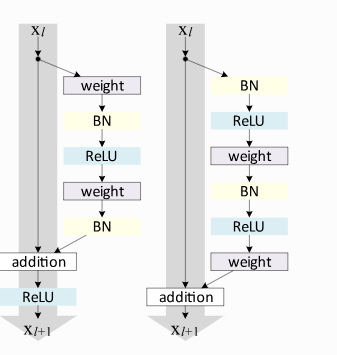

On the left we have original resnet block where activation is applied after skip connection, whereas on right we have pre-activation resnet block. The latter is shown to perform better for very deep networks since the identity matrix(gradient of the residual connection) isnt harmed by any non-linear activation applied to it

In [13]:
# Conv initialized with kaiming int, but uses fan-out instead of fan-in mode
# Fan-out focuses on the gradient distribution, and is commonly used in ResNets
resnet_kernel_init = nn.initializers.variance_scaling(2.0, mode='fan_out', distribution='normal')

class ResNetBlock(nn.Module):
    act_fn : callable  # Activation function
    c_out : int   # Output feature size
    subsample : bool = False  # If True, we apply a stride inside F

    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(x)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)

        if self.subsample:
            x = nn.Conv(self.c_out, kernel_size=(1, 1), strides=(2, 2), kernel_init=resnet_kernel_init)(x)

        x_out = self.act_fn(z + x)
        return x_out

* If subsample = True we shrink spatial dimensions by a factor of 2

In [15]:
class PreActResNetBlock(ResNetBlock):
    @nn.compact
    def __call__(self, x, train=True):
        # Network representing F
        z = nn.BatchNorm()(x, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    strides=(1, 1) if not self.subsample else (2, 2),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)
        z = nn.BatchNorm()(z, use_running_average=not train)
        z = self.act_fn(z)
        z = nn.Conv(self.c_out, kernel_size=(3, 3),
                    kernel_init=resnet_kernel_init,
                    use_bias=False)(z)

        if self.subsample:
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)
            x = nn.Conv(self.c_out,
                        kernel_size=(1, 1),
                        strides=(2, 2),
                        kernel_init=resnet_kernel_init,
                        use_bias=False)(x)

        x_out = z + x
        return x_out

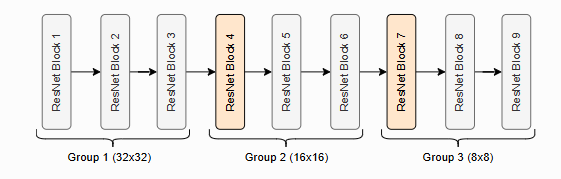

The orange blocks denote ResNet blocks with downsampling

### The Resnet Block



In [16]:
class ResNet(nn.Module):
    num_classes : int
    act_fn : callable
    block_class : nn.Module # Flexible to use ResNetBlock or PreActResNetBlock
    num_blocks : tuple = (3, 3, 3)
    c_hidden : tuple = (16, 32, 64)

    @nn.compact
    def __call__(self, x, train=True):
        # A first convolution on the original image to scale up the channel size
        x = nn.Conv(self.c_hidden[0], kernel_size=(3, 3), kernel_init=resnet_kernel_init, use_bias=False)(x)
        if self.block_class == ResNetBlock:  # If pre-activation block, we do not apply non-linearities yet
            x = nn.BatchNorm()(x, use_running_average=not train)
            x = self.act_fn(x)

        # Creating the ResNet blocks
        for block_idx, block_count in enumerate(self.num_blocks):
            for bc in range(block_count):
                # Subsample the first block of each group, except the very first one.
                subsample = (bc == 0 and block_idx > 0)
                # ResNet block
                x = self.block_class(c_out=self.c_hidden[block_idx],
                                     act_fn=self.act_fn,
                                     subsample=subsample)(x, train=train)

        # Mapping to classification output
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_classes)(x)
        return x

In a surprising twist, we use SGD with momentum rather than Adam as the optimizer since it is empirically found to yield better results.

In [17]:
resnet_trainer, resnet_results = train_classifier(model_name="ResNet",
                            model_class=ResNet,
                            model_hparams={"num_classes": 10,
                            "c_hidden": (16, 32, 64),
                            "num_blocks": (3, 3, 3),
                            "act_fn": nn.relu,
                            "block_class": ResNetBlock},
                              optimizer_name="SGD",
                              optimizer_hparams={"lr": 0.1,
                                                  "momentum": 0.9,
                                                  "weight_decay": 1e-4},
                              exmp_imgs=jax.device_put(
                                  next(iter(train_loader))[0]),
                              num_epochs=200)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Comparing the pre-activation block for comparison

In [19]:
preactresnet_trainer, preactresnet_results = train_classifier      (model_name="PreActResNet",
                      model_class=ResNet,
                      model_hparams={"num_classes": 10,
                                      "c_hidden": (16, 32, 64),
                                      "num_blocks": (3, 3, 3),
                                      "act_fn": nn.relu,
                                      "block_class": PreActResNetBlock},
                      optimizer_name="SGD",
                      optimizer_hparams={"lr": 0.1,
                                          "momentum": 0.9,
                                          "weight_decay": 1e-4},
                      exmp_imgs=jax.device_put(
                          next(iter(train_loader))[0]),
                      num_epochs=200)